# Analysis of Stellar and Exoplanetary Attributes to Discover Feasibility of Carbon-Based Life in Exoplanets 
## Brief Overview of Research and Methods

The purpose of our research was to analyze the exoplanets in the NASA Exoplanet Archive and determine their habitability by determining the circumstellar habitable zone (CHZ) of their host stars. We calculated each exoplanets’ host star’s bolometric luminosity to determine the inner and outer bounds of its CHZ and see if the exoplanet was within it.  We believed that we would find at least one habitable exoplanet, and we hypothesized that all of the exoplanets we found to be habitable would have an eccentricity less than or equal to 0.4 and that their host stars would have surface temperatures less than or equal to 7500 K. We then analyzed several characteristics of these habitable exoplanets using histograms to try to ascertain what qualities of an exoplanet favor habitability, and whether or not these qualities supported our hypothesis.  

## Importing the Dataset and Packages

In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

df = pd.read_csv('dataset.csv', low_memory=False)

# Saving for later, when we will get to the deduplication process
planet_names = df["pl_name"]

controv_flags_col = df['pl_controv_flag']

## Filtering Process

Our filtering process consisted of two steps: the removal of exoplanets with a controversial flag of 1 and the removal of duplicate entries. 

### Removal of Controversial Flags


Exoplanets with a controversial flag of 1 have a questioned existence. We thus transformed the dataset into a Pandas dataframe and then used the “loc” method in Pandas to remove all entries with a controversial of 1. By doing this, we have ensured that our data is accurate with a confirmed existence among all exoplanets.

In [3]:
df = df.loc[controv_flags_col != 1]
df.reset_index(drop=True, inplace=True)

### Deduplication

The NASA Exoplanet Archive has over 35,000 entries as of August 2022, but this includes duplicate entries for exoplanets. To eliminate the duplicate entries, we arranged all of the entries in ascending order based on the publication date of each planet. We intended on only keeping the last occurrence of a particular exoplanet, since it corresponded to the entry with the most recent publication date and thus the most accurate information about the exoplanet.  

In [4]:
duplicate_count = planet_names.value_counts()
duplicate_count

TrES-2 b                 31
GJ 436 b                 21
HAT-P-7 b                20
KOI-13 b                 19
HD 209458 b              19
                         ..
K2-290 b                  1
K2-290 c                  1
OGLE-2013-BLG-0132L b     1
K2-292 b                  1
Kepler-56 d               1
Name: pl_name, Length: 5071, dtype: int64

In [5]:
df = df.sort_values('disc_pubdate', ascending=True)

df = df.drop_duplicates(subset=['pl_name'], keep='last')

df.reset_index(drop=True, inplace=True)

## CHZ Process

The goal of the CHZ process was to ultimately determine which exoplanets lied within the CHZ of their host star. Throughout the process, we considered several attributes as detailed below.  The bolometric luminosity was the core of these calculations, as it was necessary to determine the inner and outer bounds of the CHZ. 

### Standard Stellar Luminosity and Visual Absolute Magnitude

The first step was to determine each host star's visual absolute magnitude from its standard luminosity. The visual absolute magnitude was needed to calculate the bolometric magnitude, which could then be used to determine the bolometric luminosity. 

In [6]:
for i in range(0, len(df)):

    # The values for luminosity in the dataset are represented as logs, so
    # if there is a value, the actual luminosity (in solar luminosities)
    # is 10 to the power of that value

    if pd.notna(df['st_lum'][i]):
        df['st_lum'][i] = 10**(df['st_lum'][i])

    # If there's not a luminosity value, but there are stellar radius and
    # temperature values, the luminosity can be calculated using the
    # Stefan-Boltzmann law, with all untis in terms of the Sun's physical
    # parameters (the Sun's temperature is 5778 K and the stellar radius is
    # already in terms of the Sun's radius)

    if ((pd.isna(df['st_lum'][i])) & ((pd.notna(df['st_teff'][i])) & (pd.notna(df['st_rad'][i])))):
        df['st_lum'][i] = (df['st_rad'][i]**2) * ((df['st_teff'][i]/5778)**4)

    # Otherwise, at least the luminosity and at least one of the stellar radius
    # and stellar temperature are missing, so it is impossible to calculate
    # the star's luminosity

    else:
        pass

# After the luminosity calculations have been performed,
# planets with no values for their star's luminosity must be removed

df = df.loc[pd.notna(df['st_lum'])]

df.reset_index(drop=True, inplace=True)

# Creating a new column for absolute magnitude, based on the relation
# between absolute magnitude and luminosity (see Equation 2 in paper)

df['st_abs_mag'] = 4.83 + (-2.5*np.log10(df['st_lum']))

### Calculation of Bolometric Magnitude and Bolometric Luminosity

The inner and outer bounds of the CHZ depend on the bolometric luminosity, not just standard stellar luminosity. Bolometric luminosity is a star’s luminosity across all wavelengths, as opposed to a star’s luminosity when viewed in a particular band. The definition for bolometric magnitude follows similarly. The absolute magnitude of each star determined above was the visual absolute magnitude. To determine the bolometric magnitude and then the bolometric luminosity, a bolometric correction must be added to the visual absolute magnitude. The bolometric correction depends on a star’s spectral class (or temperature). Once we determined the bolometric magnitude for each host star, we were able to calculate the bolometric luminosity of each host star using Equation 4 in the paper. 

In [7]:
df['st_spectype'] = df['st_spectype'].astype(str)

df['bol_mag'] = 0

# The for loop below adds a bolometric magnitude for the host star of each planet
# BC is the bolometric correction, which is used to convert from absolute magnitude
# (st_abs_mag) to bolometric magnitude

for i in range(0, len(df)):
    BC = 0
    if (df['st_teff'][i] >= 2400 and df['st_teff'][i] <= 3700) or df['st_spectype'][i][0] == 'M':
        BC = -2.0
    elif (df['st_teff'][i] >= 3700 and df['st_teff'][i] <= 5200) or df['st_spectype'][i][0] == 'K':
        BC = -0.8
    elif (df['st_teff'][i] >= 5200 and df['st_teff'][i] <= 6000) or df['st_spectype'][i][0] == 'G':
        BC = -0.4
    elif (df['st_teff'][i] >= 6000 and df['st_teff'][i] <= 7500) or df['st_spectype'][i][0] == 'F':
        BC = -0.15
    elif (df['st_teff'][i] >= 7500 and df['st_teff'][i] <= 10000) or df['st_spectype'][i][0] == 'A':
        BC = -0.3
    elif (df['st_teff'][i] >= 10000 and df['st_teff'][i] <= 30000) or df['st_spectype'][i][0] == 'B':
        BC = -2.0
    df['bol_mag'][i] = df['st_abs_mag'][i] + BC

# Creating a new column for BOLOMETRIC luminosity, based on BOLOMETRIC Magnitude
# (This is different from st_lum and st_abs_mag)
# The bolometric luminosity must be used for the CHZ calculations

df['bol_lum'] = 10**((df['bol_mag']-4.74)/-2.5)

### Determining Habitability

The inner and outer bounds of the CHZ of each host star could now be determined using bolometric luminosity, as seen in Equations 5 and 6 in the paper. 

In [8]:
# Defining the inner boundary of the CHZ (formula from Reference 12)

df['inner_CHZ'] = np.sqrt(df['bol_lum']/1.1)

# Defining the outer boundary of the CHZ (formula from Reference 12)

df['outer_CHZ'] = np.sqrt(df['bol_lum']/0.53)

# Creating a new column to determine if planets are habitable

df['Habitable'] = None

planets = []

for i in range(0, len(df)):

    # First if statement checks if there are values for the planet's
    # semi-major axis and eccentricity

    if ((pd.notna(df['pl_orbsmax'][i])) & (pd.notna(df['pl_orbeccen'][i]))):

        # If the eccentricity is less than 0.2, the average distance from the planet
        # to its star can be approximated by its semi-major axis
        # If the average distance is in the CHZ range, we say the planet is
        # habitable

        if df['pl_orbeccen'][i] <= 0.2:
            if ((df['pl_orbsmax'][i] >= df['inner_CHZ'][i]) & (df['pl_orbsmax'][i] <= df['outer_CHZ'][i])):
                df['Habitable'][i] = 'Yes'
                planets.append(df['pl_name'][i])
            else:
                df['Habitable'][i] = 'No'

        # If the eccentricity is greater than 0.2, we must use a formula for
        # the average distance and then check if this
        # average distance is in the CHZ range

        else:
            avg_dist = df['pl_orbsmax'][i] * (1+((df['pl_orbeccen'][i]**2)/2))
            if ((avg_dist >= df['inner_CHZ'][i]) & (avg_dist <= df['outer_CHZ'][i])):
                df['Habitable'][i] = 'Yes'
                planets.append(df['pl_name'][i])
            else:
                df['Habitable'][i] = 'No'

    # If there is no value for the planet's semi-major axis, but there are values
    # for its orbital period, eccentricity, and the star's mass, we can use
    # Kepler's 3rd Law to calculate its semi-major axis, and then perform
    # the eccentricity check again to determine the average orbiting distance
    # and then determine if this average distance is in the CHZ

    elif ((pd.isna(df['pl_orbsmax'][i])) & (pd.notna(df['pl_orbeccen'][i])) & (pd.notna(df['pl_orbper'][i])) & (pd.notna(df['st_mass'][i]))):

        # Convering the orbital period from days to years

        orb_per_year = df['pl_orbper'][i]/365

        # Using Kepler's Third Law: T^2/a^3 = 1/M, with T in years, a in AU
        # and M in solar masses, so a = cubert(T^2 * M)

        df['pl_orbsmax'][i] = np.cbrt((orb_per_year**2)*df['st_mass'][i])

        if df['pl_orbeccen'][i] <= 0.2:
            if ((df['pl_orbsmax'][i] >= df['inner_CHZ'][i]) & (df['pl_orbsmax'][i] <= df['outer_CHZ'][i])):
                df['Habitable'][i] = 'Yes'
                planets.append(df['pl_name'][i])
            else:
                df['Habitable'][i] = 'No'

        else:
            avg_dist = df['pl_orbsmax'][i] * (1+((df['pl_orbeccen'][i]**2)/2))
            if ((avg_dist >= df['inner_CHZ'][i]) & (avg_dist <= df['outer_CHZ'][i])):
                df['Habitable'][i] = 'Yes'
                planets.append(df['pl_name'][i])
            else:
                df['Habitable'][i] = 'No'

    # Otherwise, there are too many values missing to determine if the planet
    # is habitable. CND = Can Not Determine

    else:
        df['Habitable'][i] = 'CND'

print(planets, len(planets))

['BD-06 1339 c', 'GJ 3293 c', 'GJ 3323 c', 'HD 10180 g', 'HD 103891 b', 'HD 10442 b', 'HD 10697 b', 'HD 109286 b', 'HD 125612 b', 'HD 128356 b', 'HD 132406 b', 'HD 137388 b', 'HD 13908 c', 'HD 141937 b', 'HD 142415 b', 'HD 147513 b', 'HD 159868 b', 'HD 1605 c', 'HD 16175 b', 'HD 165155 b', 'HD 17674 b', 'HD 18015 b', 'HD 181720 b', 'HD 190647 b', 'HD 213240 b', 'HD 214823 b', 'HD 219415 b', 'HD 221585 b', 'HD 222582 b', 'HD 27969 b', 'HD 34445 b', 'HD 43197 b', 'HD 564 b', 'HD 63765 b', 'HD 65216 b', 'HD 73534 b', 'HD 9174 b', 'HD 99109 b', 'KELT-6 c', 'Kapteyn c', 'Kepler-1318 b', 'Kepler-1593 b', 'Kepler-16 b', 'Kepler-1647 b', 'Kepler-1649 c', 'Kepler-167 e', 'Kepler-174 d', 'Kepler-421 b', 'Kepler-454 c', 'Kepler-47 c', 'Kepler-553 c', 'Kepler-62 f', 'WASP-41 c', 'WASP-47 c', 'Wolf 1061 d'] 55


## Visualizing Our Data


### Percent of Controversial Flags

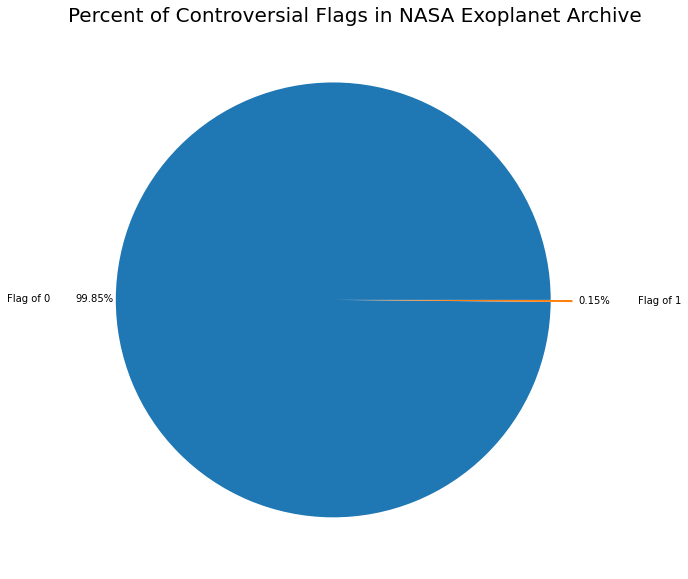

In [8]:
num_pl_flag_0 = controv_flags_col.value_counts()[0]
num_pl_flag_1 = controv_flags_col.value_counts()[1]

nums = [num_pl_flag_0, num_pl_flag_1]
labels = ["Flag of 0", "Flag of 1"]

explode = (0.1, 0)

fig, ax = plt.subplots(figsize=(10,10))
ax.pie(nums, labels=labels,autopct='%1.2f%%',explode=explode, pctdistance=1.1, labeldistance=1.3)
plt.title('Percent of Controversial Flags in NASA Exoplanet Archive',size=20)
plt.show()

### Duplicate Values

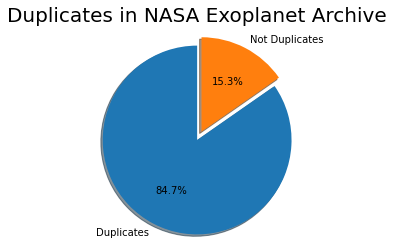

In [21]:
num_duplicates = planet_names.duplicated().sum()
total_planets = len(planet_names)
num_not_duplicated = total_planets - num_duplicates

labels = ['Duplicates', 'Not Duplicates']
pcnt_duplicates = num_duplicates / total_planets
pcnt_non_duplicates = num_not_duplicated / total_planets

sizes = [pcnt_duplicates, pcnt_non_duplicates]
explode = (0.1, 0)
fig1, ax1 = plt.subplots()

ax1.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Duplicates in NASA Exoplanet Archive',size=20)

plt.show()

### Pie Chart of Habitability

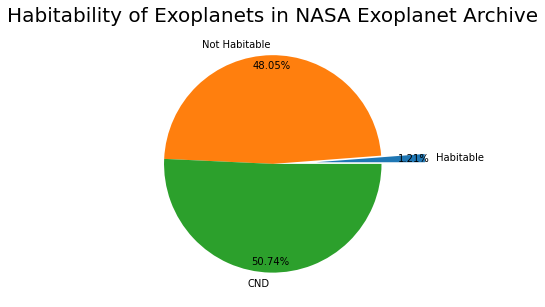

In [12]:
nums = [61, 2417, 2552]
labels = ['Habitable', 'Not Habitable', 'CND']
explode=[0.4,0,0]
fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(nums, labels=labels,autopct='%1.2f%%',pctdistance=0.9,explode=explode)
plt.title('Habitability of Exoplanets in NASA Exoplanet Archive',size=20)
plt.show()

In [9]:
df2 = df.loc[df['Habitable']=='Yes']

### Histogram of Eccentricity Values of Habitable Exoplanets

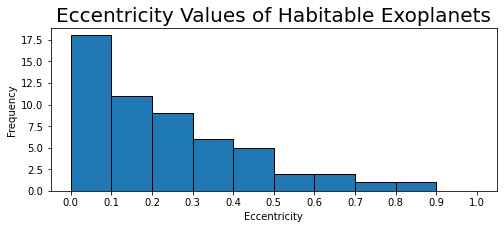

In [20]:
bins = np.linspace(0,1,11)
plt.figure(figsize=(8,3))
plt.hist(df2['pl_orbeccen'],bins=bins,ec='black')
plt.xticks(ticks=bins)
plt.title('Eccentricity Values of Habitable Exoplanets',size=20)
plt.xlabel('Eccentricity')
plt.ylabel('Frequency')
plt.show()

### Histogram of Semi-Major Axis Values of Habitable Exoplanets

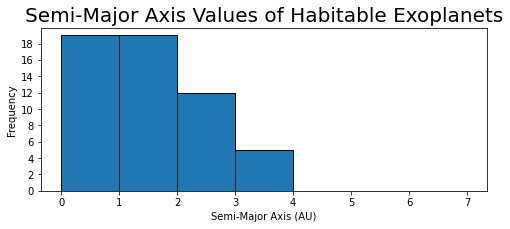

In [22]:
plt.figure(figsize=(8,3))
bins=np.linspace(0,7,8)
plt.hist(df2['pl_orbsmax'],bins=bins,ec='black')
plt.title('Semi-Major Axis Values of Habitable Exoplanets',size=20)
plt.xticks(bins)
plt.yticks(np.arange(0,20,2))
plt.xlabel('Semi-Major Axis (AU)')
plt.ylabel('Frequency')
plt.show()

### Histogram of Host Star Temperature Values of Habitable Exoplanets

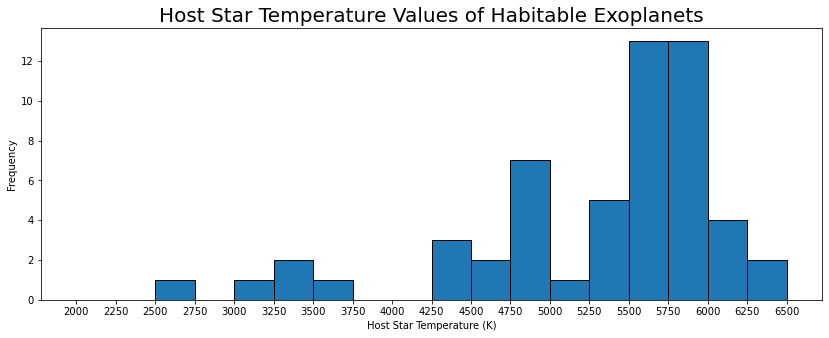

In [23]:
plt.figure(figsize=(14,5))
bins=np.linspace(2000,6500,19)
plt.hist(df2['st_teff'],ec='black',bins=bins)
plt.xticks(bins)
plt.xlabel('Host Star Temperature (K)')
plt.ylabel('Frequency')
plt.title('Host Star Temperature Values of Habitable Exoplanets',size=20)
plt.show()

## Comparing Our Data to the PHL

In [12]:
our_planets = pd.read_csv('habitable-planets.csv')
phl_planets = pd.read_csv('PHL-dataset-simplified.csv')

our_planets = our_planets['pl_name']
phl_planets = phl_planets['pl_name']

print(our_planets)
print(phl_planets)

similar_planets = []

for our_planet in our_planets:
    for phl_planet in phl_planets:
        if our_planet == phl_planet:
            similar_planets.append(our_planet)

print(similar_planets,len(similar_planets))

0      BD-06 1339 c
1         GJ 3293 c
2         GJ 3323 c
3        HD 10180 g
4       HD 103891 b
5        HD 10442 b
6        HD 10697 b
7       HD 109286 b
8       HD 125612 b
9       HD 128356 b
10      HD 132406 b
11      HD 137388 b
12       HD 13908 c
13      HD 141937 b
14      HD 142415 b
15      HD 147513 b
16      HD 159868 b
17        HD 1605 c
18       HD 16175 b
19      HD 165155 b
20       HD 17674 b
21       HD 18015 b
22      HD 181720 b
23      HD 190647 b
24      HD 213240 b
25      HD 214823 b
26      HD 219415 b
27      HD 221585 b
28      HD 222582 b
29       HD 27969 b
30       HD 34445 b
31       HD 43197 b
32         HD 564 b
33       HD 63765 b
34       HD 65216 b
35       HD 73534 b
36        HD 9174 b
37       HD 99109 b
38         KELT-6 c
39        Kapteyn c
40    Kepler-1318 b
41    Kepler-1593 b
42      Kepler-16 b
43    Kepler-1647 b
44    Kepler-1649 c
45     Kepler-167 e
46     Kepler-174 d
47     Kepler-421 b
48     Kepler-454 c
49      Kepler-47 c


## Exporting Our Data

In [25]:
for planet in planets:
    print(planet)

with open('habitable-planets.csv', 'w', newline='') as csvfile:
    fieldnames = ['number', 'pl_name']
    planet_count = 0

    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for planet in planets:
        planet_count += 1
        writer.writerow({'number': planet_count, 'pl_name': planet})

BD-06 1339 c
GJ 3293 c
GJ 3323 c
HD 10180 g
HD 103891 b
HD 10442 b
HD 10697 b
HD 109286 b
HD 125612 b
HD 128356 b
HD 132406 b
HD 137388 b
HD 13908 c
HD 141937 b
HD 142415 b
HD 147513 b
HD 159868 b
HD 1605 c
HD 16175 b
HD 165155 b
HD 17674 b
HD 18015 b
HD 181720 b
HD 190647 b
HD 213240 b
HD 214823 b
HD 219415 b
HD 221585 b
HD 222582 b
HD 27969 b
HD 34445 b
HD 43197 b
HD 564 b
HD 63765 b
HD 65216 b
HD 73534 b
HD 9174 b
HD 99109 b
KELT-6 c
Kapteyn c
Kepler-1318 b
Kepler-1593 b
Kepler-16 b
Kepler-1647 b
Kepler-1649 c
Kepler-167 e
Kepler-174 d
Kepler-421 b
Kepler-454 c
Kepler-47 c
Kepler-553 c
Kepler-62 f
WASP-41 c
WASP-47 c
Wolf 1061 d
